# ROC Calculation and Plotting Functions

Function <b>roc_calc</b> is to calculate ROC for one or multiple scores. 
* It takes the DataFrame, target column name (like ‘G_B’), and one or multiple score column names as input parameters. 
* The score can be either first stage score or second stage bad rate. The function can identify first or second stage by itself and calculate ROC accordingly. 
* Value of the target column must be GOOD/BAD/INDET. Upper or lower case doesn’t matter. 
* The function returns a Series of ROC for all score(s) that we passed in, with score name(s) as index name(s).
* The function can be combined with $groupby$ to calculate ROC within each subpopulation. 

Function <b>roc_plot</b> is to plot roc curve(s) for one or multiple scores.
* Just like roc_calc, roc_plot takes the DataFrame, target column name (like ‘G_B’), and one or multiple score column name(s) as input parameters.
* The Legend shows ROC value(s) and lift(s) of the score(s). The first score parameter we put in will be determined as the Base. Any scores we put in after will be compared to the Base and given a lift value. 

Function <b>lift</b> is to calculate the lift between two ROCs.
* It takes 2 ROC values as input parameters. Whichever put in first is the base. 
* It calculates lift this way: (new_roc - base_roc) / base_roc.
* The function returns a float.

In [13]:
# Function Definition. 

def roc_calc(df, target_name, *score_name):
    import pandas as pd
    import numpy as np
    
    df[target_name] = df[target_name].str.upper()
    df = df[(df[target_name] == 'GOOD') | (df[target_name] == 'BAD')]
    
    result = {}
    for score in score_name:
        piv = df.pivot_table(df,index=score,columns=target_name,aggfunc='size',fill_value=0)
        if piv.index.max() <= 1:     # if it's second stage bad rate, sort from high to low
            piv = piv.sort_index(ascending=False)
        else:                        # if it's first stage score, sort from low to high
            piv = piv.sort_index()
        piv['Bad%'] = (piv.BAD.cumsum(axis=0))/(piv.BAD.sum())
        piv['Good%'] = (piv.GOOD.cumsum(axis=0))/(piv.GOOD.sum())
        roc = (piv['Good%'] - piv['Good%'].shift(1)) * (piv['Bad%'] + piv['Bad%'].shift(1))/2   
        roc = sum(roc.replace(np.nan,0))        
        result[score] = roc
    result = pd.Series(result)
    result.name = 'ROC'
    return result
    
    
def roc_plot(df, target_name, *score_name):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    df[target_name] = df[target_name].str.upper()
    df = df[(df[target_name] == 'GOOD') | (df[target_name] == 'BAD')]
    
    fig = plt.figure(figsize=(6,6))
    
    roc_lst = []
    
    for score in score_name:
        piv = df.pivot_table(df,index=score,columns=target_name,aggfunc='size',fill_value=0)
        if piv.index.max() <= 1:     # if it's second stage bad rate, sort from high to low
            piv = piv.sort_index(ascending=False)
        else:                        # if it's first stage score, sort from low to high
            piv = piv.sort_index()
        piv['Bad%'] = (piv.BAD.cumsum(axis=0))/(piv.BAD.sum())
        piv['Good%'] = (piv.GOOD.cumsum(axis=0))/(piv.GOOD.sum())
        roc = (piv['Good%'] - piv['Good%'].shift(1)) * (piv['Bad%'] + piv['Bad%'].shift(1))/2   
        roc = sum(roc.replace(np.nan,0)) *100  
        roc_lst.append(roc)
        
        if len(roc_lst) == 1:
            plt.plot(piv['Good%'], piv['Bad%'], lw=2, label = "{}: {:.2f}%, Base".format(score, roc))
        else:
            lift = 100* (roc - roc_lst[0])/roc_lst[0]
            plt.plot(piv['Good%'], piv['Bad%'], lw=2, label = "{}: {:.2f}%, Lift={:.2f}%".format(score, roc,lift))
        
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.xlabel('Cumulative % of Goods')
    plt.ylabel('Cumulative % of Bads')
    plt.grid()
    plt.title('ROC curve')
    plt.legend(prop={'size':13}, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
    
def lift(base_roc, new_roc):
    return (new_roc-base_roc)/base_roc

In [14]:
# Set up
import pandas as pd
import numpy as np
    
# Put in the path of the data file and column names inside of the apostrophe
path = r'\\neptune\RAD\4 Models\Scorecard 7.0\Subpopulation Study\Lift\data prepare\DEV\Total.csv'
target = 'G_B'
score1 = 'SC60_Stage1_Points'
score2 = 'SC70_Stage1_Points'
score3 = 'SC60_Stage2_Points' 
score4 = 'SC70_Stage2_Points'
#score5 = ...   # add more if you need

# Load the data file
df = pd.read_csv(path)
df.head()

,LN_Key,A_R,SC70_Stage1_Points,SC70_Stage2_Points,SC70_Segment,SC60_Stage1_Points,SC60_Stage2_Points,SC60_Segment,Model_State,FICCLAV8_SCORE,...,CLOSE_DATE,OPEN_YEARMONTH,CLOSE_YEARMONTH,DR_ORIGBAL,GAIN,G_B,DAYS_LATE,PAIDMO,BAD_CLOSECODE_Indicator,TimePeriod
0,L008428,Accepts,198,0.511509,7F,184,0.6447,6F,FL,477.0,...,20180327.0,201708,201803.0,NaN,753.72,INDET,653,4,0,Dev
1,L025832,Accepts,238,0.248504,7F,231,0.3312,6F,FL,608.0,...,20180906.0,201702,201809.0,NaN,4412.10,GOOD,460,16,0,Dev
2,L025651,Accepts,239,0.323428,7D,231,0.3791,6D,CA,638.0,...,20190304.0,201703,201903.0,9141.34,-3081.20,BAD,370,19,1,Dev
3,L025855,Accepts,195,0.613916,7M,189,0.6429,6K,CA,NaN,...,20171106.0,201608,201711.0,NaN,2722.80,GOOD,576,19,0,Dev
4,L026313,Accepts,228,0.303659,7D,225,0.3238,6D,CA,555.0,...,NaN,201701,NaN,NaN,893.86,GOOD,-18,33,0,Dev


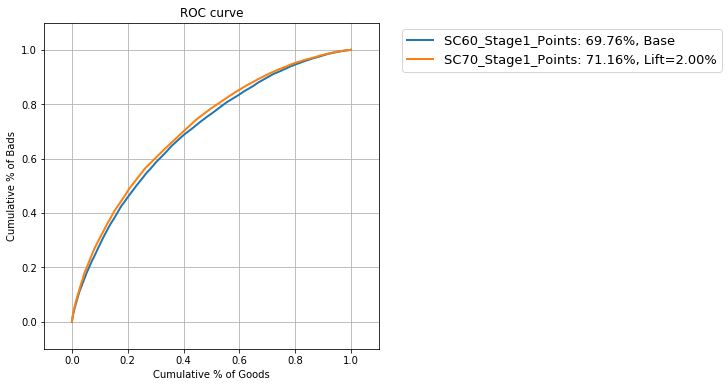

In [21]:
# Example 1: plot the ROC Curve for two scores

roc_plot(df, target, score1, score2)

In [16]:
# Example 2: calculate ROC for one score
result = roc_calc(df, target, score1)
result

SC60_Stage1_Points    0.697617
Name: ROC, dtype: float64

In [17]:
# Example 3: calculate ROC for two scores
result = roc_calc(df, target, score1, score2)

# Calculte the Lift between the two scores and add it into the result
result['Lift'] = lift(result[score1], result[score2])

result

SC60_Stage1_Points    0.697617
SC70_Stage1_Points    0.711558
Lift                  0.019984
Name: ROC, dtype: float64

In [18]:
# Example 4: calculate ROC for two scores within each Segment
result = df.groupby('SC70_Segment').apply(roc_calc, target, score1, score2)

# Put in the Lift column
result['Lift'] = np.vectorize(lift)(result[score1], result[score2])

# Export result to Excel. Comment out if you don't need it.
result.to_excel("output.xlsx")  

result

ROC,SC60_Stage1_Points,SC70_Stage1_Points,Lift
SC70_Segment,,,
7A,0.677731,0.706034,0.041761
7B,0.674665,0.694914,0.030014
7C,0.666813,0.692968,0.039223
7D,0.712364,0.717424,0.007103
7E,0.689806,0.704998,0.022024
7F,0.724936,0.727495,0.003529
7G,0.707950,0.735889,0.039464
7H,0.713438,0.730124,0.023388
7I,0.682888,0.687413,0.006626


In [19]:
# Example 5: calculate ROC for two scores group by State and Segment

# Define FICO Segment and State Group
seg_map = {
    '7A': 'Valid',
    '7B': 'Valid',
    '7C': 'Valid',
    '7D': 'Valid',
    '7E': 'Valid',
    '7F': 'Valid',
    '7G': 'Valid',
    '7H': 'Valid',
    '7I': '9000s',
    '7J': '9000s',
    '7K': '9000s',
    '7L': '9000s',
    '7M': 'Missing',
    '7N': 'Missing'
}

state_map = {
    'CA': 'CA',
    'TX': 'TX',
    'FL': 'FL',
    'AZ': 'Others',
    'CO': 'Others',
    'ID': 'Others',
    'MN': 'Others',
    'NM': 'Others',
    'NV': 'Others',
    'OR': 'Others',
    'UT': 'Others',
    'WA': 'Others',
    'WY': 'Others'
}

df['Seg_FICO'] = df['SC70_Segment'].map(seg_map)
df['State_Group'] = df['Model_State'].map(state_map)

# Calculate ROC for two scores within each state and segment.
result = df.groupby(['State_Group','Seg_FICO']).apply(roc_calc, target, score1, score2)

# Put in the Lift column
result['Lift'] = np.vectorize(lift)(result[score1],result[score2])

# Export result to Excel. Comment out if you don't need it.
result.to_excel("output.xlsx")  

result

ROC                   SC60_Stage1_Points  SC70_Stage1_Points      Lift
State_Group Seg_FICO                                                  
CA          9000s               0.682888            0.687413  0.006626
            Missing             0.593959            0.601685  0.013007
            Valid               0.712173            0.724650  0.017519
FL          9000s               0.664344            0.673044  0.013095
            Missing             0.547091            0.549321  0.004076
            Valid               0.721664            0.727314  0.007828
Others      9000s               0.658276            0.682075  0.036153
            Missing             0.635129            0.616072 -0.030004
            Valid               0.707004            0.731658  0.034872
TX          9000s               0.663899            0.666372  0.003725
            Missing             0.589351            0.592220  0.004869
            Valid               0.700304            0.715987  0.022394